# Running a multilevel sweep parameter study with PhysiCOOL


In [1]:
%matplotlib notebook
from typing import List
from pathlib import Path

import numpy as np

from physicool.config import ConfigFileParser
from physicool.optimization import PhysiCellBlackBox
from physicool.processing import Cells

def params_updater(new_values: List[float]) -> None:
    """
    Updates the cell speed and the migration bias.

    Parameters
    ----------
    new_values: list[float]
        The parameter values for (1) the cell speed,
        and (2) the migration bias.
    """
    cell_definition_name = "cancer"

    # Read the data from the file
    xml_parser = ConfigFileParser()
    cell_data = xml_parser.read_cell_data(cell_definition_name)

    # Update values
    cell_data.motility.speed = new_values[0]
    cell_data.motility.bias = new_values[1]
    xml_parser.update_params(cell_definition_name, cell_data)

def output_processor(output_path: Path) -> np.ndarray:
    cells = Cells(time=12, storage_path=output_path)
    coordinates = cells.get_cell_positions()
    
    return np.array([coord[1] for coord in coordinates])

my_model = PhysiCellBlackBox(params_updater, output_processor)

## Generating data (optional)
We do not have any data, so we need to generate some datasets. This step could be replaced by loading some target data from a file, though. However, it is important to make sure that the data fits the model output format!

In [2]:
params = [3.0, 0.8]
target_data = my_model.run(params)
print(target_data)

[ 493.03700364  493.03788519  493.02447045  493.02228878  493.03430266
  493.02965164  493.04409742  134.72353816  493.02118459  493.04055559
  493.02640998  493.0377498   493.02308128  493.0341071   493.02171003
  493.02853493  275.54288035  493.04274874  493.02167169  493.03766356
  493.0340129  -493.02497617 -493.04094017 -493.03850967 -493.04235905
 -493.03967329 -493.04406104 -493.03635735 -493.02777879 -493.03703997
 -493.03669165 -493.02319074 -493.03950766 -493.03387087 -493.03772941
 -406.22360423 -493.02398973 -493.03531181 -405.93691714 -493.02361363
 -493.0283383  -493.04239782  493.03985102  493.03821735  345.14655731
  318.49666103  493.04436997  290.28612282  493.02644485  493.04440179
  450.98883919  493.03007516  493.0241912   493.04058078  493.02291375
  493.02836204  493.02325335  493.03203642  493.03070005  298.30127469
  493.03215526  493.04030529  493.02120195  493.02303133  493.03774078
  493.04419791  493.03120455  493.03746145  493.04112738  493.02136808
  493.

## Running the multilevel sweep pipeline

### The calibration model
First of all, **we need to define our "black-box"**. PhysiCOOL can help us do this, using `OptModel`.

`OptModel` will create a black-box function that **takes in a parameters dictionary**, **runs a PhysiCell simulation** with the updated parameter values and then **computes the metric you select** when initializing the model

You can **call this function independently**, and it will output an array with the values for the metric you choose. Here, we will be using it **inside our multilevel parameter sweep**.

<IPython.core.display.Javascript object>


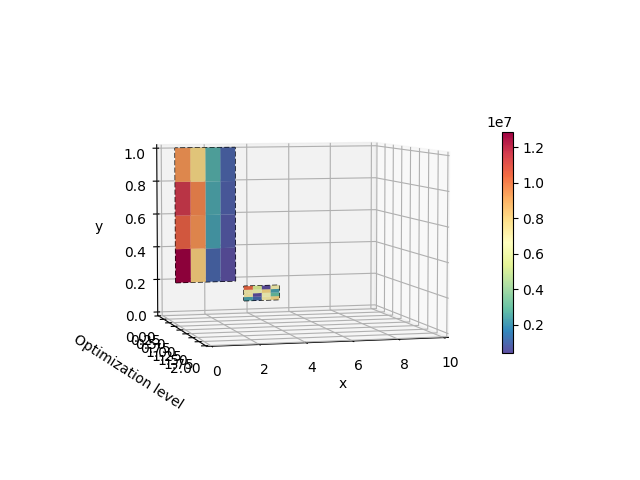

Optimal value found: 3.4; 0.20099999999999998


In [3]:
from physicool.optimization import MultiSweep

# Create our multisweep pipeline
number_of_levels = 2
points_per_direction = 5
percent_per_direction = 0.7

ms = MultiSweep(my_model, target_data, n_levels=number_of_levels, 
                npdir=points_per_direction, ppdir=percent_per_direction)

# Select initial value for the parameter sweep
ms.set_fit_value(2.0, 0.6)
ms.set_param_bounds((0, None), (0, 1))

# Run multisweep and get optimal parameters
x, y = ms.run_sweep()

print(f'Optimal value found: {x}; {y}')

In [5]:
ms.results[0]

array([[13588874.06018772,  8754845.43403183,  1623837.82393454,
          475797.02122521,   465914.65234935],
       [10741654.72987697,  9972657.51347235,  1730728.35407942,
          584522.51006477,   467109.96246415],
       [13133332.64849604,  7689711.41457127,  2329042.49637551,
          705980.6776773 ,   467894.9499033 ],
       [12287340.21223431, 12148245.15250804,  2121919.88365789,
          928525.91900246,   472368.88481205],
       [11488019.4441702 , 12489153.87901251,  3679642.21694473,
         1134688.23611817,   469170.93245393]])